# FORECASTING

Once the Exploratory Data Analysis is complete, it would be possible to advance into the selection of a proper model to deliver the forecasting.

Let's start with the linear models, models which are related to linear regression but consider the correlation between diferent points in time.

 - Autoregressive Models
 - Moving Average Models
 - Autoregressive Integrated Moving Average Models
 - Vectorial Autoregression Models
 - Hierarquical Models

## AutoRegressive Model (AR)

 - Past values have an effect on current values
 - The order of the AR model corresponds to the number of days incorporated

$$y_t = \beta_1y_{t-1} + \beta_2y_{t-2} + \beta_3y_{t-3} + \cdots + \beta_py_{t-p}$$

## Moving Average Model (MA)

 - The value of the dependent variable ($y_t$) depends on the previos days error terms

$$y_t = \varepsilon_t + \alpha_1\varepsilon_{t-1} + \alpha_2\varepsilon_{t-2} + \cdots \alpha_q\varepsilon_{t-q}$$

or

$$X_t = \mu +\varepsilon_t + \theta_1\varepsilon_{t-1} + \cdots + \theta_q\varepsilon_{t-q}$$

 - $\mu$: mean of series
 - $\theta_1, \cdots , \theta_q$: parameters
 - $\varepsilon_t, \varepsilon_{t-1}, \varepsilon_{t-q}$: white noise error terms
 - $q$: order of the MA model

## Auto Regressive Moving Average (ARMA)

 - Combination of AR and MA
 
$$y_t = \beta_1y_{t-1} + \beta_2y_{t-2} + \beta_3y_{t-3} + \cdots + \beta_py_{t-p} + \varepsilon_t + \alpha_1\varepsilon_{t-1} + \alpha_2\varepsilon_{t-2} + \cdots \alpha_q\varepsilon_{t-q}$$

## AutoRegressive Integrated Moving Average Model (ARIMA)

 - Also called Box-Jenkins
 - Adds differencing to the ARMA model
 - Subtracts the current value from the previous one, transforming a non-stationary time-series into a stationary one.
 
   - First Order Diferencing: addresses linear trends
   $$z_i = y_i - y_{i-1}$$
   - Second Order Diferencing: addesses quadratic trends
   $$z_i = (y_i - y_{i-1}) - (y_{i-1} - y_{i-2})$$
   
Three parameters define the model:

 - $p$: Number of autoregressive terms (AR Order)
 - $d$: Number of nonseasonal differences (Differencing Order)
 - $q$: Number of moving-average terms (MA Order)

## Obtaining the parameters

In order to obtain the correct terms. There are a few important functions to use:

### Auto Correlation Function (ACF)
 - Correlation between observations of the current point in time and the observations at **all previous points in time**
 - Determine the **optimal number of MA terms**
 
 ### Partial Auto Correlation Function (PACF)
 - Correlation between observations made at **two points in time**
 - Accounts for any influence from other data points
 - Determine the **optimal number of AR terms**
 - The number of terms used determines the order of the model

## Loading the desired dataset

Before jumping into the models:

 - Select the appropriate period
 - Load the object informations
 - Prepare the Training and Testsets

In [2]:
from main import load_tower

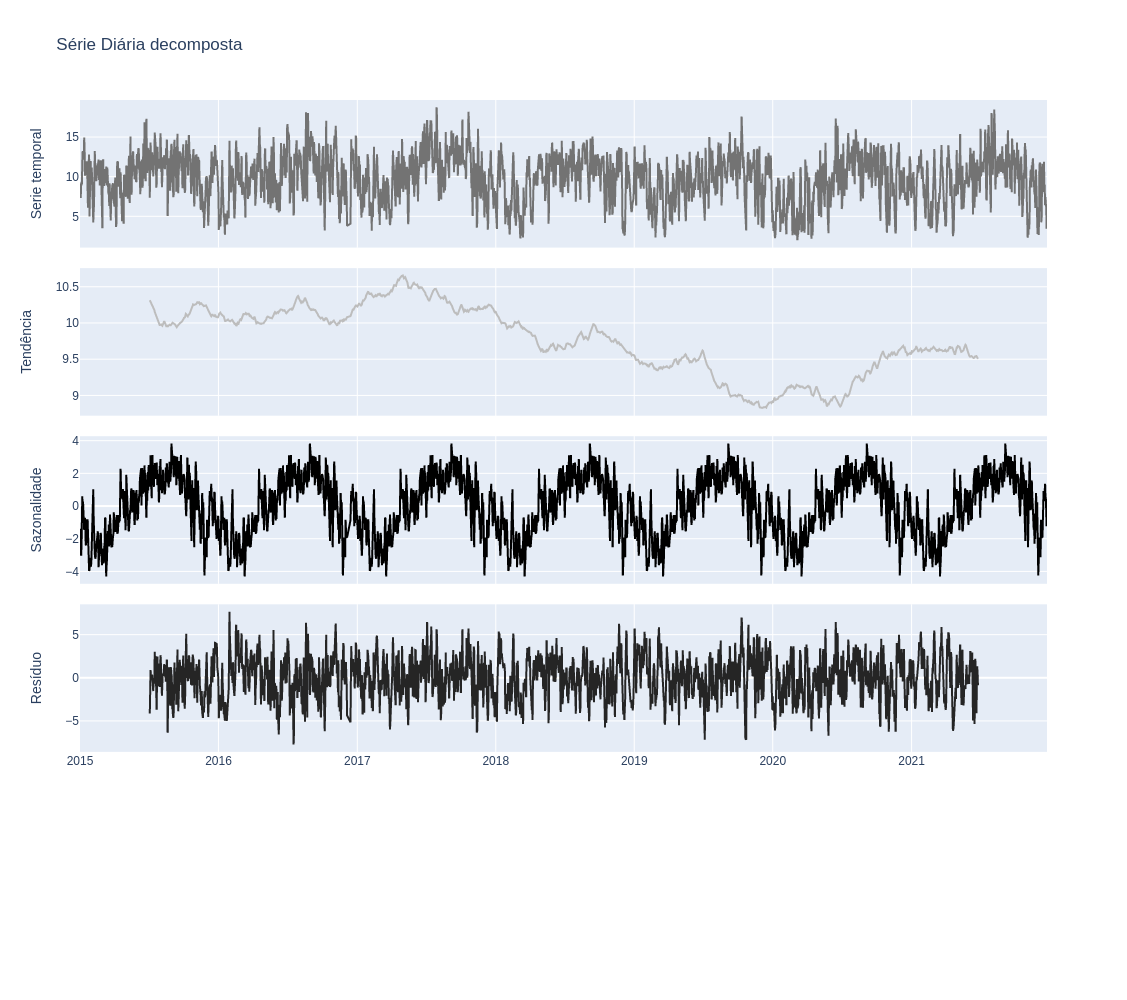

In [3]:
period = 'd'
Tower = load_tower(pickefile='UT001.pkl')

## Modelagem

Devemos considerar agora a relevância dos horizontes de previsão. Dentro do contexto de previsão de geração de energia elétrica, existem diferentes usos para diferentes horizontes de previsão do recurso. A tabela abaixo indica alguns desses horizontes:

|  **Escala** |      **Horizonte**      |                            **Aplicação**                            |
|:-----------:|:-----------------------:|:-------------------------------------------------------------------:|
| imediata    | até 8 horas             | Operações de rede, ações de regulação                               |
| curto-prazo | dia à frente            | Planejamento de despacho econômico, segurança de mercado de energia |
| longo-prazo | múltiplos dias à frente | Planejamento de manutenção, planejamento da operação                |

Considerando a tabela, a modelagem abaixo visa obter informações relevantes para decisões de curto-prazo, desta forma, dentro de um horizonte diário.

### Separação em Treino e Teste

Considerando então o horizonte de relevância de curto-prazo, foi separado um modelo de teste e treino considerando a previsão de dois dias a frente.

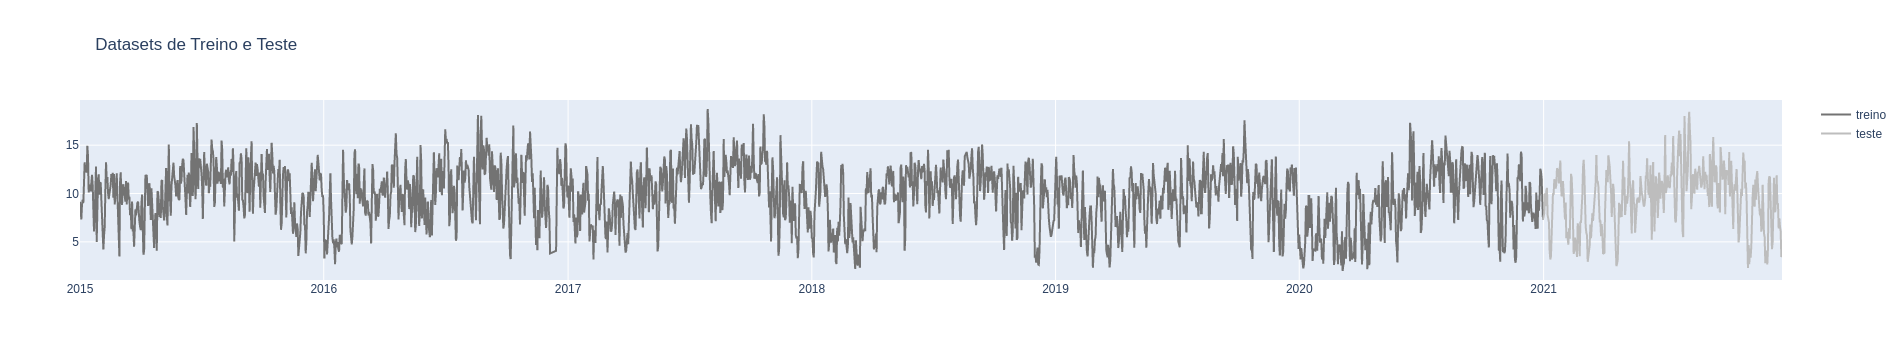

In [17]:
Tower.build_sets(period=period, split='2021-01-01', plot=True, export=False)

## Escolha de um modelo

A escolha de qualquer modelo depende fortemente dos testes estatísicos implementados na análise exploratória. Considerando o horizonte diário, temos o seguinte comportamento:

              Augmented Dickey-Fuller Test               
                          DAILY                          
---------------------------------------------------------
Estatística ADF:
-5.483883443739295
---------------------------------------------------------
p-valor:
2.2525050461455363e-06
---------------------------------------------------------
lags utilizados:
21
---------------------------------------------------------
N observações utilizadas:
2518
Valores Críticos:
	1%: -3.432949673919829
	5%: -2.8626885257380397
	10%: -2.5673814041175183
---------------------------------------------------------
Hipótese Nula Rejeitada? - True
Série Temporal ESTACIONÁRIA


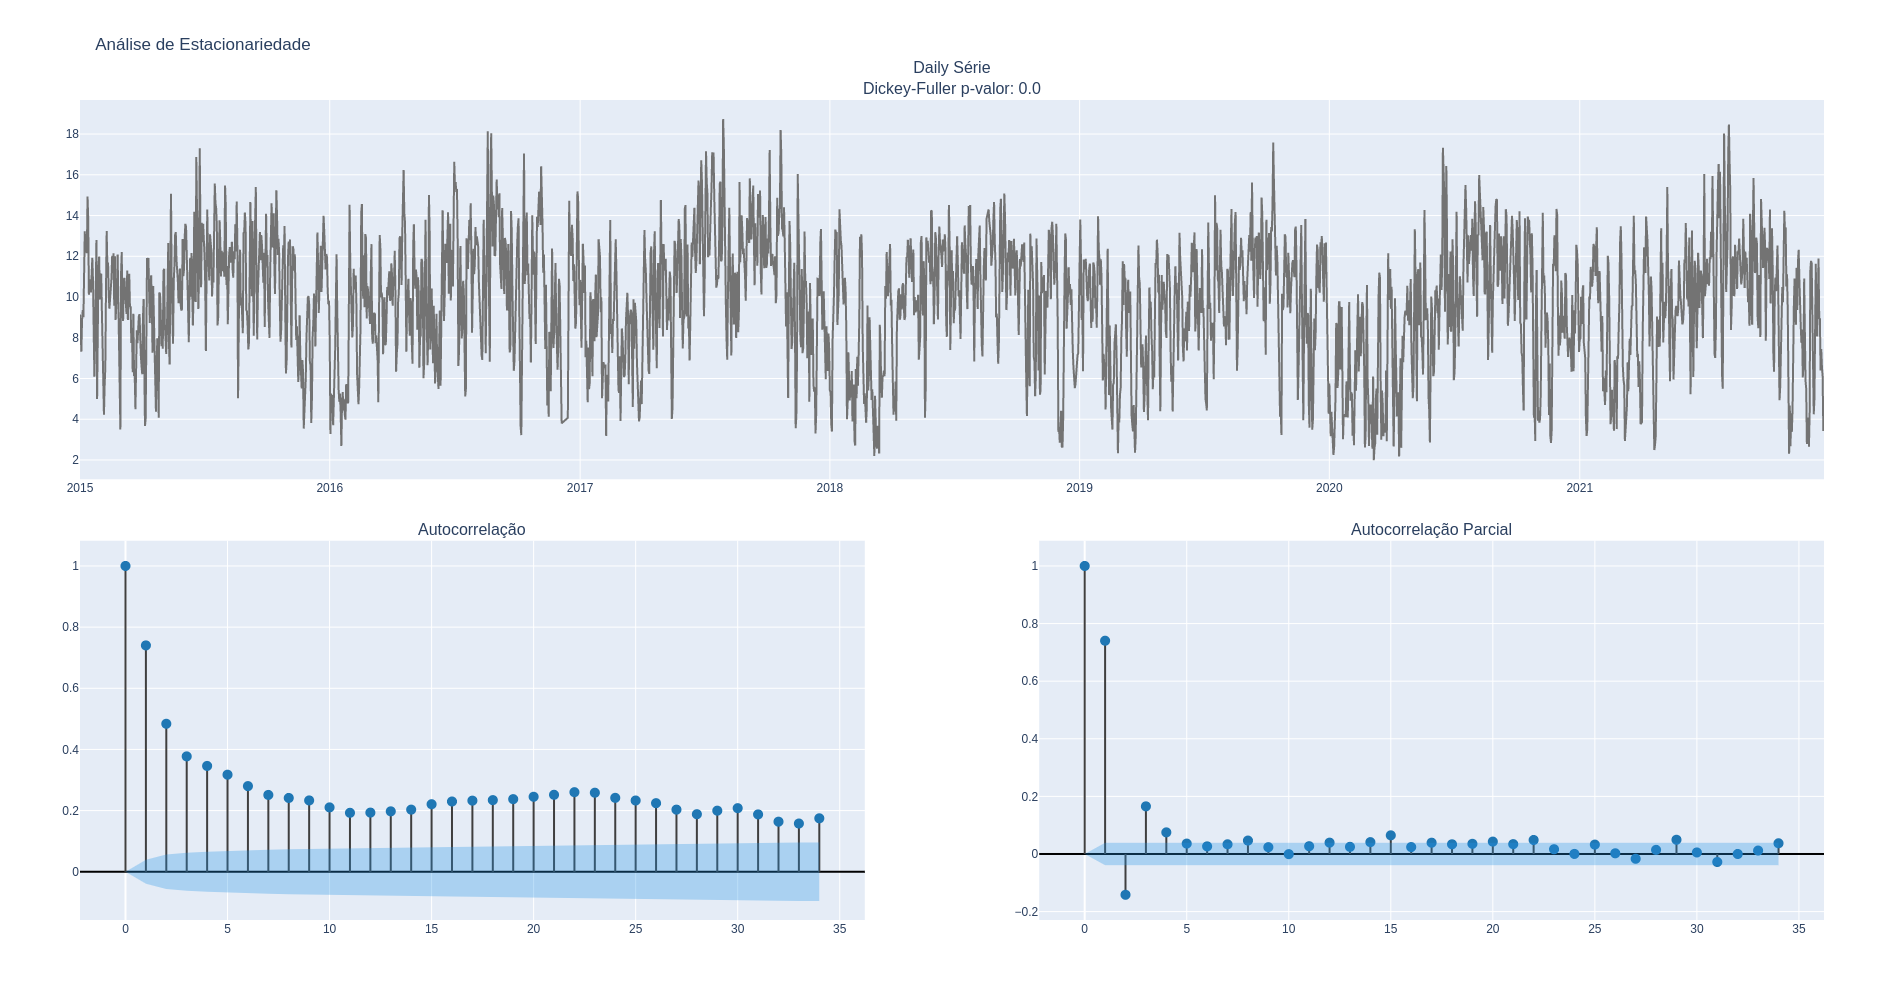

In [7]:
Tower.stationarity(period=period, plot=True, verbose=True, export=False)

Observa-se que, apesar de estacionária, a série possui um autocorrelação significativa. Note também que não existe um período típico para as autocorrelações e é muito provável que uma diferenciação de primeira ordem seja suficiente para reduzir esse comportamento.

Abaixo a mesma análise de estacionariedade para um lag de 1 dia.

              Augmented Dickey-Fuller Test               
                          DAILY                          
---------------------------------------------------------
Estatística ADF:
-28.008226871035475
---------------------------------------------------------
p-valor:
0.0
---------------------------------------------------------
lags utilizados:
3
---------------------------------------------------------
N observações utilizadas:
2536
Valores Críticos:
	1%: -3.432931203247706
	5%: -2.8626803690000653
	10%: -2.5673770613761207
---------------------------------------------------------
Hipótese Nula Rejeitada? - True
Série Temporal ESTACIONÁRIA


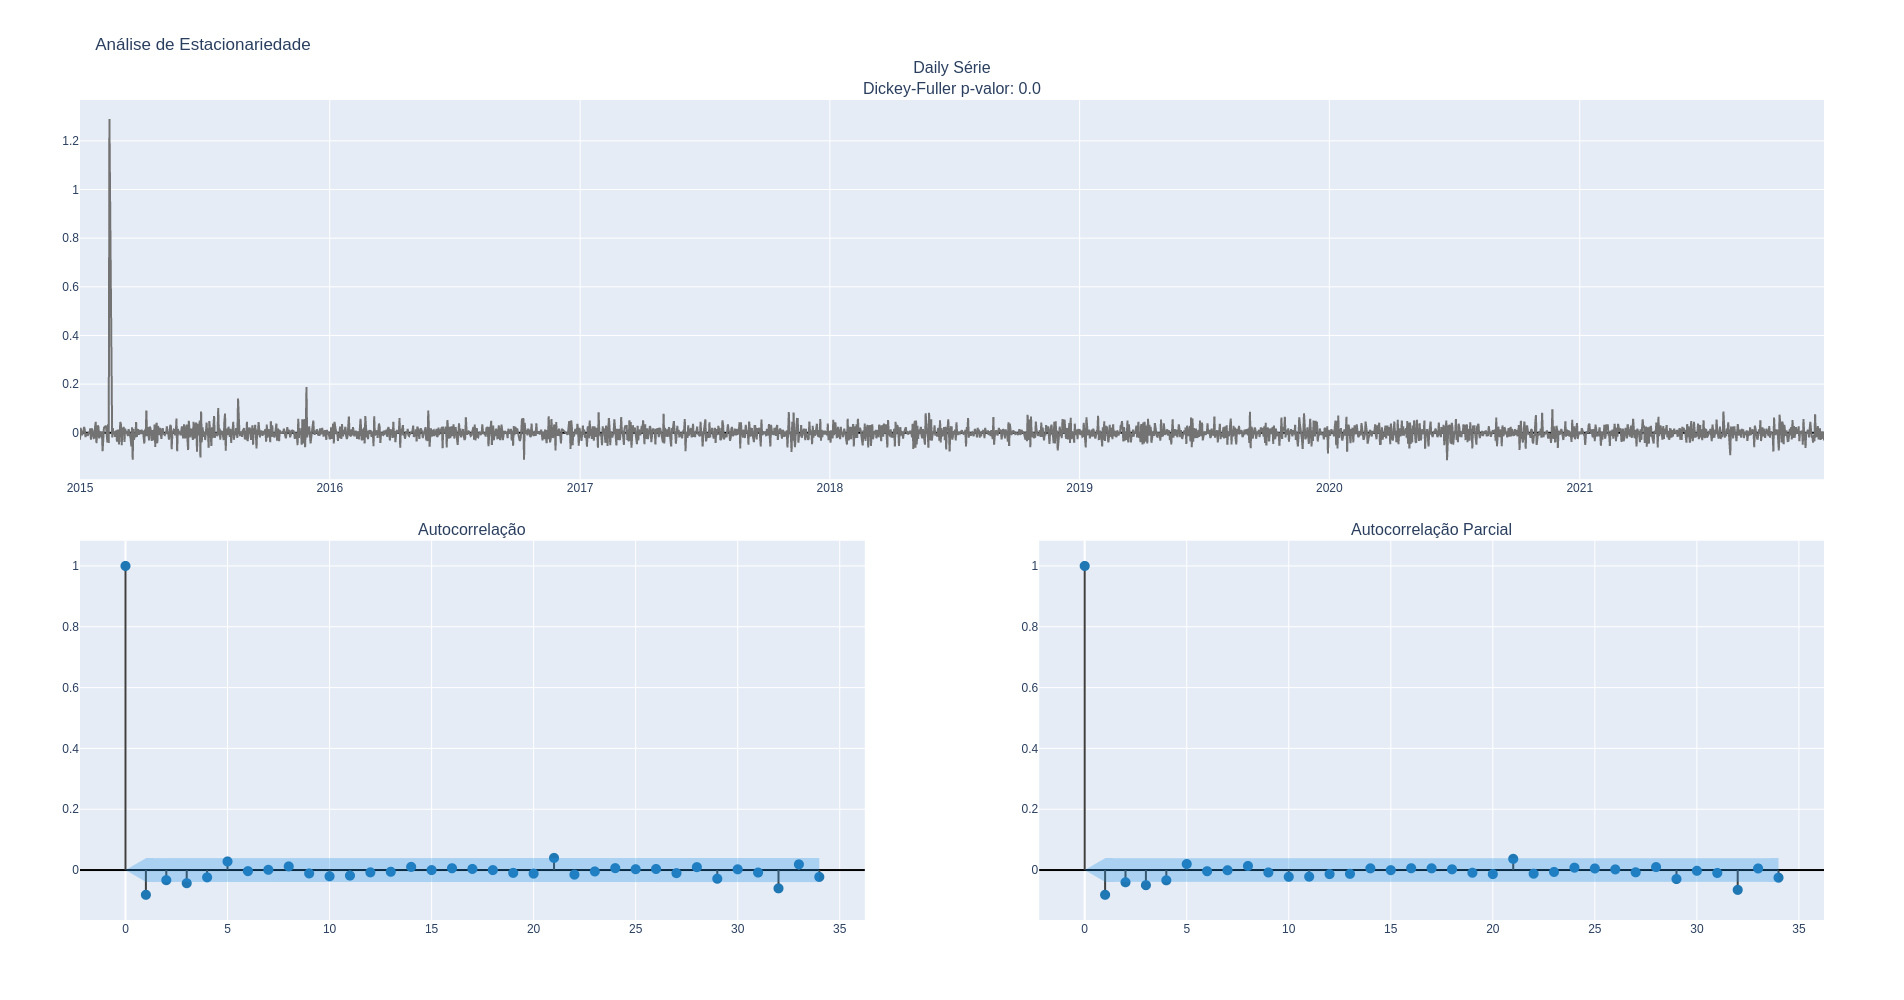

In [13]:
Tower.stationarity(period=period, plot=True, diff=1, verbose=True, export=False)

Isso indica que de fato existia uma forte correlação entre o a velocidade do vento do dia, com a velocidade no dia anterior.

Esses dados indicam que:

 - Série de observaçoes diárias é ESTACIONÁRIA
 - Existe uma forte correlação entre o dia anterior e o dia observado

Considerando então que um modelo ARIMA é um bom candidato como preditor temos:
 - A ordem $p$ é dada pelo lag imediatamente anterior aos valores de PACF cortarem o limite superior = 4
 - A ordem $d$ é dado pelo grau de diferenciação necessário para tornar a série estacionária, neste caso 1, considerando que, apesar de estacionária a série possuia um grau de autocorrelação muito forte
 - A ordem $q$ é dada pelo lag imediatamente anterior aos valores de ACF cortarem o limite superior = 4

## Forecast

In [40]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import plotly.express as px
import plotly.graph_objs as go
import statsmodels.api as sm
import yaml

from plotly.subplots import make_subplots

from services import (translation, theme, timeseries)

color_cycle = theme.get_colors()

def plot_forecast(train, test, forecast):
    train_trace = go.Scatter(
                name='Train',
                x=train.index,
                y=train['mean'],
                mode='lines',
                line=dict(color=next(color_cycle)))

    #Appends last element of training to connect line
    test_df = train.iloc[-1:].append(test)    
    test_trace = go.Scatter(
                name='Test',
                x=test_df.index,
                y=test_df['mean'],
                mode='lines',
                line=dict(color=next(color_cycle)))

    forecast_trace = go.Scatter(
                name='Forecast',
                x=forecast.index,
                y=forecast,
                mode='lines',
                line=dict(color=next(color_cycle)))

    fig = go.Figure()
    fig.add_trace(train_trace)
    fig.add_trace(test_trace)
    fig.add_trace(forecast_trace)
    fig.update_layout(title_text='Forecast',
                        xaxis_showticklabels=True)

    fig.show()

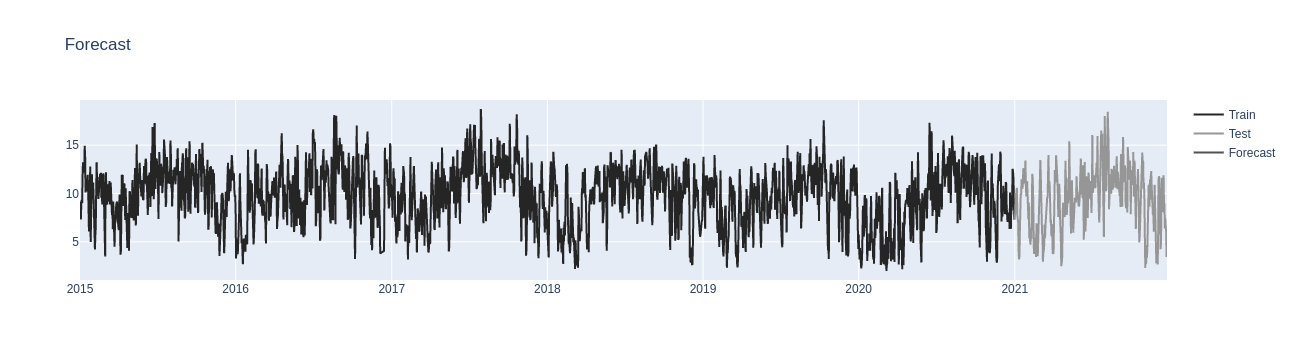

In [86]:
model = ARIMA(Tower.trainset['mean'], order=(1,0,1))
res = model.fit()
forecast = res.predict(
    start=len(Tower.trainset),
    dynamic=True
)

plot_forecast(Tower.trainset, Tower.testset, forecast)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.11385D+00    |proj g|=  3.86238D-01


 This problem is unconstrained.



At iterate    5    f=  2.08660D+00    |proj g|=  2.77105D-01

At iterate   10    f=  2.07906D+00    |proj g|=  5.43902D-02

At iterate   15    f=  2.07468D+00    |proj g|=  3.88661D-01

At iterate   20    f=  2.07294D+00    |proj g|=  1.07579D-01

At iterate   25    f=  2.07268D+00    |proj g|=  1.86197D-02

At iterate   30    f=  2.07237D+00    |proj g|=  1.11651D-01

At iterate   35    f=  2.07189D+00    |proj g|=  2.04650D-02

At iterate   40    f=  2.07154D+00    |proj g|=  1.61171D-01

At iterate   45    f=  2.07137D+00    |proj g|=  8.06063D-02

At iterate   50    f=  2.07111D+00    |proj g|=  6.45691D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

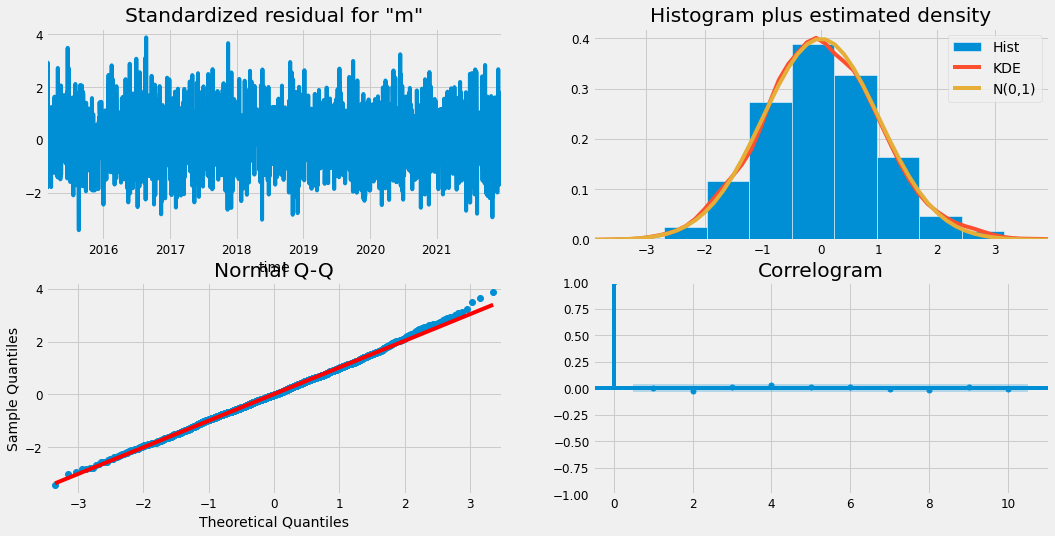

In [120]:
import warnings

import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

mod = sm.tsa.statespace.SARIMAX(Tower.dataset['mean'],
                                order=(4, 0, 4),
                                seasonal_order=(4, 0, 4, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

results.plot_diagnostics(figsize=(16, 8))
plt.show()

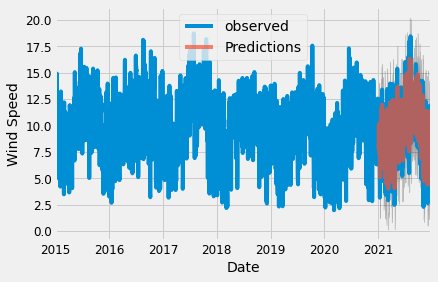

In [121]:
start_forecast = len(Tower.trainset)
pred = results.get_prediction(start=start_forecast,
                              dynamic=False)
pred_ci = pred.conf_int()

ax = Tower.dataset['mean'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Predictions', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Wind Speed')
plt.legend()

plt.show()

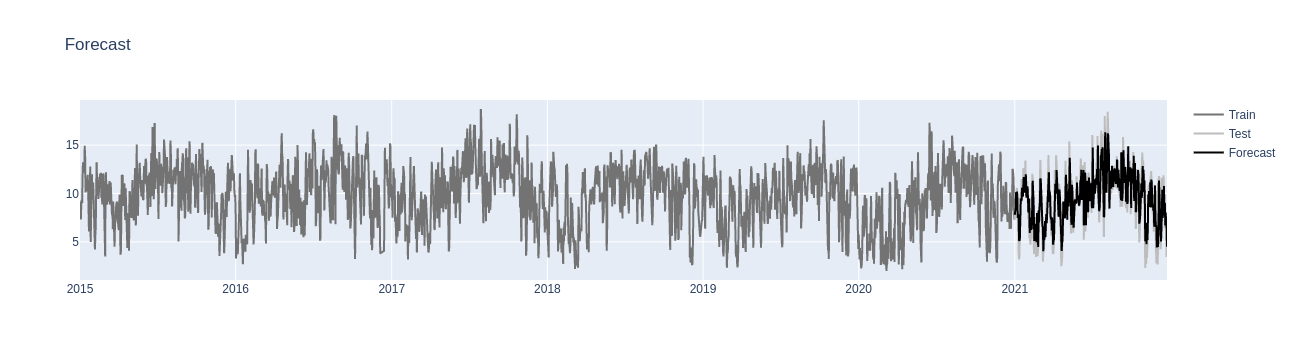

In [122]:
plot_forecast(Tower.trainset, Tower.testset, pred.predicted_mean)

In [123]:
from statsmodels.tools.eval_measures import rmse
error=rmse(Tower.testset['mean'], pred.predicted_mean)
error

2.0336139158766464

In [125]:
from pmdarima.arima import auto_arima
step_wise=auto_arima(Tower.trainset['mean'], 
 exogenous= Tower.trainset['mean'],
 start_p=1, start_q=1, 
 max_p=7, max_q=7, 
 d=1, max_d=12,
 trace=True, 
 error_action='ignore', 
 suppress_warnings=True, 
 stepwise=True)

ModuleNotFoundError: No module named 'pmdarima'